<center> <h1> TENSORFLOW : FLOWERS IMAGES CLASSIFICATION</h1></center>

Dans ce tutoriel, nous allons classer des images de fleurs. On crée un classificateur d'images à l'aide d'un modèle **keras.Sequential**
et charge les données à l'aide de **preprocessing.image_dataset_from_directory**. 
Nous etudions les concepts suivants :
 - Chargement efficace d'un ensemble de données à partir du disque.
 - Identifier le surapprentissage et appliquer des techniques pour l'atténuer, y compris l'augmentation des données et l'abandon.
 
 Ce tutoriel suit un workflow d'apprentissage automatique de base :

- Examiner et comprendre les données
- Construire un pipeline d'entrée
- Construire le modèle
- Former le modèle
- Tester le modèle
- Améliorer le modèle et répéter le processus

### Chargement des librairies 

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


import pathlib #pour les images de fleurs 

### Le dataset
On utilise un ensemble de données d'environ 3 700 photos de fleurs. L'ensemble de données contient 5 sous-répertoires, un par classe :
- flower_photo/
- daisy/
- dandelion/
- roses/
- sunflowers/
- tulips/

In [42]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin = dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [43]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


#### Affichage de quelques fleurs roses

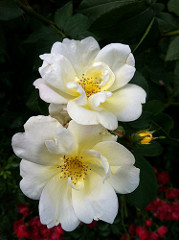

In [51]:
roses=list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

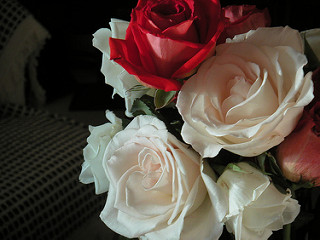

In [52]:
PIL.Image.open(str(roses[1]))

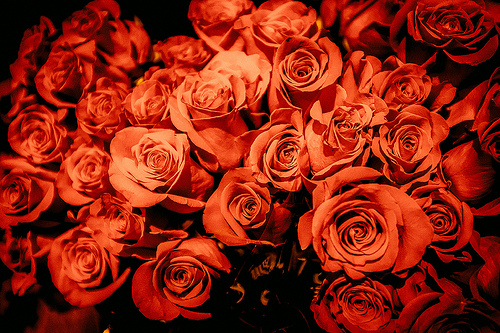

In [53]:
PIL.Image.open(str(roses[2]))

#### Et de quelques tulipes 

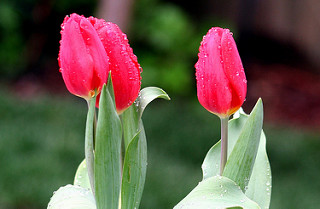

In [54]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

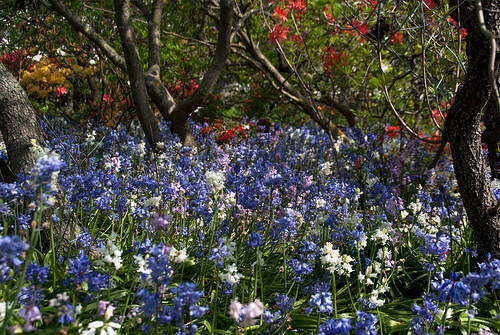

In [55]:
PIL.Image.open(str(tulips[1]))

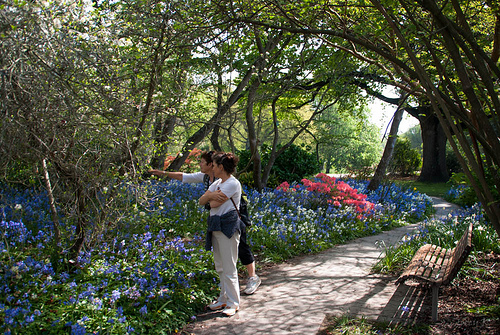

In [56]:
PIL.Image.open(str(tulips[2]))

### Creation du jeu de données
On tuilise **image_dataset_from_directory** pour charger les images sur le disque. On  passera alors d'un répertoire d'images 
sur un disque à un **tf.data.Dataset**.

 Quelques paramètres 

In [58]:
batch_size = 32
img_height = 180
img_width = 180

In [60]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2,
    subset = "training",
    seed = 456,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


-  Division du dataset en dataset train & test : 80 % et 20% respectivement

In [61]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=456,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


On trouve les noms de classe dans l'attribut **class_names** sur ces ensembles de données. Ceux-ci correspondent aux noms des répertoires par ordre alphabétique.

In [65]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualisation des données
Nous allons afficher douze images de fleurs.

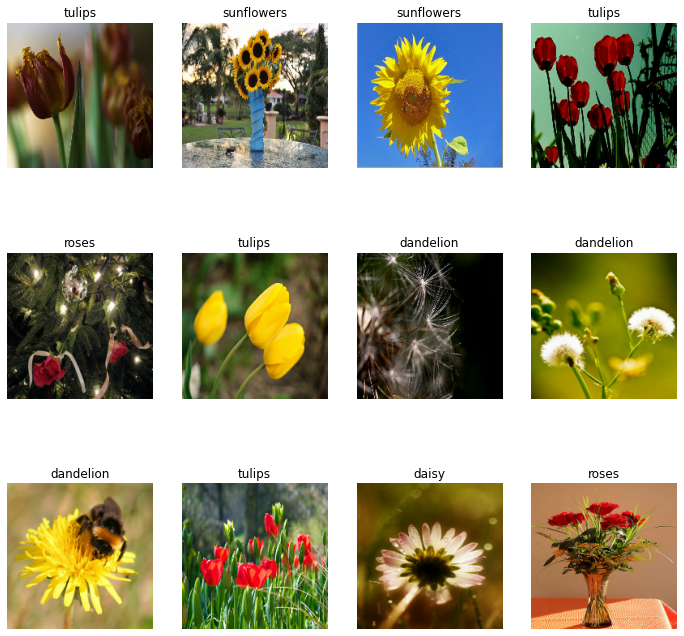

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12,12))
for images,labels in train_ds.take(1) :
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

On entraine un modèle à l'aide de ces ensembles de données en les transmettant à **model.fit** dans un instant. 
Si on veut, on peut également itérer manuellement sur l'ensemble de données et récupérer des lots d'images

In [70]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


#### NOTE :
L'**image_batch** est un tenseur de la forme (32, 180, 180, 3) . Il s'agit d'un lot de 32 images de forme 180x180x3 (la dernière dimension fait référence aux canaux de couleur RVB). Le label_batch est un tenseur de la forme (32,) , ce sont les labels correspondants aux 32 images.

On peut également utiliser **numpy()* sur les tenseurs **image_batch** et **labels_batch** pour les convertir en **numpy.ndarray** .

## Configurer l'ensemble de données pour les performances

Assurons-nous d'utiliser la prélecture tamponnée afin que vous puissiez produire des données à partir du disque sans que les E/S ne deviennent bloquantes. Ce sont deux méthodes importantes que nous devont utiliser lors du chargement des données.

**Dataset.cache()** sert à conserver les images en mémoire après leur chargement sur le disque au cours de la première époque. Cela garantira que l'ensemble de données ne deviendra pas un goulot d'étranglement lors de l'entraînement de votre modèle. Si notre ensemble de données est trop volumineux pour tenir dans la mémoire, on peut également utiliser cette méthode pour créer un cache sur un disque performant.

**Dataset.prefetch()** chevauche le prétraitement des données et l'exécution du modèle pendant la formation.


In [71]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardiser les données
Les valeurs du canal RVB sont dans la plage **[0, 255]** . Ce n'est pas idéal pour un réseau de neurones ; en général, on doit  chercher à rendre nos valeurs d'entrées petites. Ici, nous normaliserons les valeurs pour qu'elles soient dans la plage **[0, 1]** en utilisant une couche de redimensionnement.

In [76]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Il y a deux façons d'utiliser cette couche : 
 - On peut soit l'appliquer à l'ensemble de données en appelant **map**
 - Soit on inclue la couche dans la definition de notre modèle ( ce qui peut simplifier le déploiement)

In [77]:
# Premier cas 
normalized_ds = train_ds.map(lambda x, y : (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image =image_batch[0]
# verification : valeurs des pixels entre 0 et 1 
print(np.min(first_image), np.max(first_image))

0.0 0.95098025


## Créer le modèle
Le modèle se compose de trois blocs de convolution avec une couche de pool maximale dans chacun d'eux. Il y a une couche entièrement connectée avec 128 unités au-dessus qui est activée par une fonction d'activation relu . Ce modèle n'a pas été réglé pour une grande précision, le but de ce tutoriel est de montrer une approche standard.

In [78]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compiler le modèle
Pour ce tutoriel, on choisi les **optimizers.Adam** optimiseur et les **losses.SparseCategoricalCrossentropy** fonction de perte. Pour afficher la précision de l'entraînement et de la validation pour chaque époque d'entraînement, on transmet l'argument **metrics**.

In [79]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Résumé du modèle
Visualisez toutes les couches du réseau à l'aide de la méthode summary du modèle :

In [80]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

## Entrainer le modèle

In [81]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 108s 1s/step - loss: 1.3191 - accuracy: 0.4540 - val_loss: 1.0605 - val_accuracy: 0.5599
Epoch 2/10
92/92 [==============================] - 109s 1s/step - loss: 1.0027 - accuracy: 0.6076 - val_loss: 1.0285 - val_accuracy: 0.5967
Epoch 3/10
92/92 [==============================] - 109s 1s/step - loss: 0.8355 - accuracy: 0.6805 - val_loss: 0.9691 - val_accuracy: 0.6267
Epoch 4/10
92/92 [==============================] - 112s 1s/step - loss: 0.6481 - accuracy: 0.7551 - val_loss: 1.0530 - val_accuracy: 0.6076
Epoch 5/10
92/92 [==============================] - 127s 1s/step - loss: 0.4266 - accuracy: 0.8481 - val_loss: 1.1368 - val_accuracy: 0.6281
Epoch 6/10
92/92 [==============================] - 141s 2s/step - loss: 0.2557 - accuracy: 0.9084 - val_loss: 1.4320 - val_accuracy: 0.5940
Epoch 7/10
92/92 [==============================] - 158s 2s/step - loss: 0.1613 - accuracy: 0.9455 - val_loss: 1.7033 - val_accuracy: 0.5981
Epoch 8/10
92

## Visualisez les résultats de l'entraînement
Créez des tracés de perte et de précision sur les ensembles d'apprentissage et de validation.

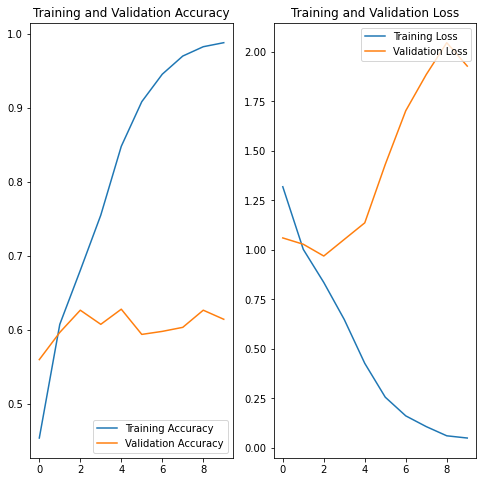

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Comme on peut le voir sur les graphiques, la précision de l'entraînement et la précision de la validation sont largement décalées et le modèle n'a atteint qu'environ 60 % de précision sur l'ensemble de validation.

Regardons ce qui s'est mal passé et essayons d'augmenter les performances globales du modèle.

## Surapprentissage
Dans les graphiques ci-dessus, la précision de la l'entrainement augmente linéairement au fil du temps, tandis que la précision de la validation stagne autour de 60%. De plus, la différence de précision entre la précision de l'entraînement et celle de la validation est perceptible, un signe de surapprentissage .
Cela signifie que le modèle aura du mal à généraliser sur un nouvel ensemble de données.

Il existe plusieurs façons de traiter le probleme de surapprentissage. Dans ce tutoriel, nous allons utiliser l'augmentation de données et ajouterez **Dropout** à notre modèle.

## Augmentation des données
Le surapprentissage se produit généralement lorsqu'il existe un petit nombre d'exemples de formation. L'augmentation des données adopte l'approche consistant à générer des données d'entraînement supplémentaires à partir des exemples existants en les augmentant à l'aide de transformations aléatoires qui produisent des images d'apparence crédible. Cela permet d'exposer le modèle à davantage d'aspects des données et de mieux généraliser.

On implementera l'augmentation des données à l'aide des couches de **tf.keras.layers.experimental.preprocessing**. Ceux-ci peuvent être inclus dans notre modèle comme d'autres couches et exécutés sur le GPU.

In [83]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Visualisons à quoi ressemblent quelques exemples augmentés en appliquant plusieurs fois l'augmentation de données à la même image :

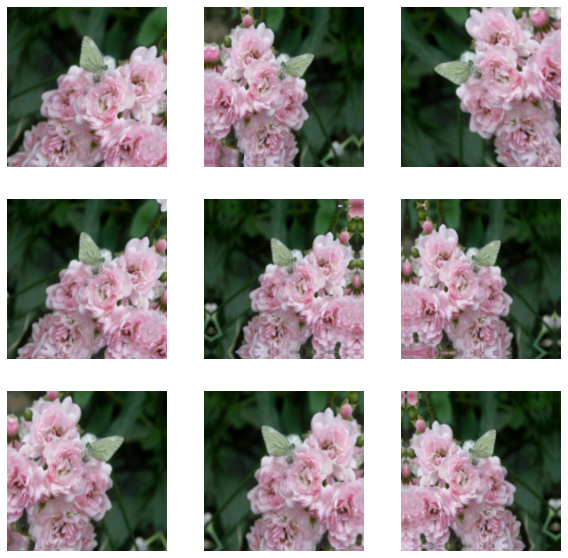

In [84]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Vous utiliserez l'augmentation de données pour entraîner un modèle en un instant.

## DropOut
Une autre technique pour réduire le surapprentissage consiste à introduire le **Dropout** dans le réseau, une forme de régularisation.

Lorsque on applique **Dropout** à une couche, il supprime de manière aléatoire (en définissant l'activation sur zéro) un certain nombre d'unités de sortie de la couche pendant le processus d'apprentissage. Le **DropOut** prend un nombre fractionnaire comme valeur d'entrée, sous la forme 0,1, 0,2, 0,4, etc. Cela signifie abandonner 10 %, 20 % ou 40 % des unités de sortie de manière aléatoire de la couche appliquée.

Créons un nouveau réseau de neurones à l'aide de **layers.Dropout** , puis formons-le à l'aide d'images augmentées.

In [85]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compiler et entraîner le modèle

In [86]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [87]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)       

In [88]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 123s 1s/step - loss: 1.2705 - accuracy: 0.4595 - val_loss: 1.0233 - val_accuracy: 0.5886
Epoch 2/15
92/92 [==============================] - 120s 1s/step - loss: 1.0100 - accuracy: 0.6035 - val_loss: 0.9783 - val_accuracy: 0.6199
Epoch 3/15
92/92 [==============================] - 121s 1s/step - loss: 0.9252 - accuracy: 0.6281 - val_loss: 0.8956 - val_accuracy: 0.6471
Epoch 4/15
92/92 [==============================] - 125s 1s/step - loss: 0.8627 - accuracy: 0.6652 - val_loss: 0.8755 - val_accuracy: 0.6730
Epoch 5/15
92/92 [==============================] - 123s 1s/step - loss: 0.7771 - accuracy: 0.7071 - val_loss: 0.8015 - val_accuracy: 0.6989
Epoch 6/15
92/92 [==============================] - 121s 1s/step - loss: 0.7548 - accuracy: 0.7098 - val_loss: 0.7350 - val_accuracy: 0.7262
Epoch 7/15
92/92 [==============================] - 120s 1s/step - loss: 0.6994 - accuracy: 0.7275 - val_loss: 0.8527 - val_accuracy: 0.6907
Epoch 8/15
92

## Visualisez les résultats de l'entraînement
Après avoir appliqué l'augmentation des données et le **DropOut**, il y a moins de surapprentissage qu'auparavant, et la précision de l'entrainement et de la validation sont plus proche.

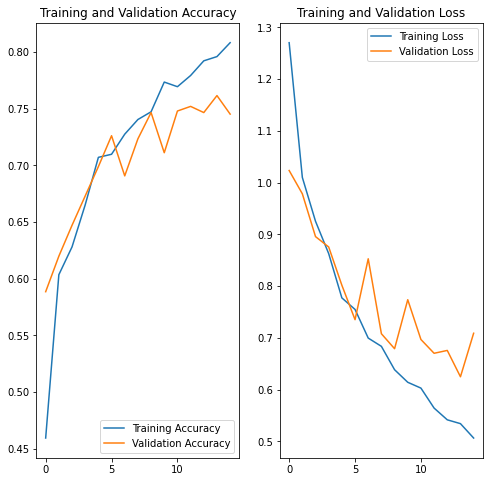

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prédiction sur de nouvelles données
Enfin, utilisons notre modèle pour classer une image qui n'était pas incluse dans les ensembles d'apprentissage ou de validation.

- **Remarque** : Les couches d'augmentation des données et de suppression sont inactives au moment de l'inférence.

In [90]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 96.64 percent confidence.
